In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sc
from scipy import linalg, stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from patsy import dmatrices

import sys
sys.path.append('..')
import attrs, utils

Variables from Fabrizio:
* `s` slopes of quantiles [mm/year].
* `B` matrix of bootstrap sampled slopes.
  * Shape: (N, 19), where $N$ is the number of bootstrap samples.
  * `B[i,j]` is the jth quantile slope from the ith bootstrapped sample [mm/year].

Computed from this:
* `coeffs` coefficients of legendre basis functions from the tide gauge
* `C` coefficients of legendre basis functions from block-bootstrapped QR slopes.
* `sigs` Significance of each coefficient.

## Generate synthetic data

array([0.00048501, 0.00041366, 0.00037696, 0.00034597, 0.00033754,
       0.0003153 , 0.00028134, 0.00027636, 0.00027226, 0.00024648,
       0.00023082, 0.00021879, 0.00020569, 0.00018951, 0.00018734,
       0.00019765, 0.00019128, 0.00016358, 0.00016699])

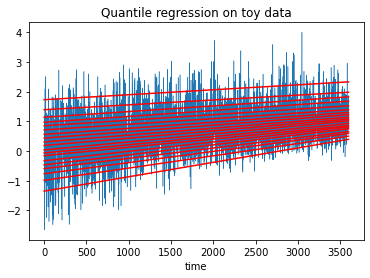

In [39]:
# Synthetic data
rng = np.random.default_rng(0)
n = 3601
data = np.zeros(n)
for i in range(n):
    data[i] = sc.stats.skewnorm.rvs(loc=1e-4*i**2/n, a=0.001*i)
timeseries = xr.DataArray(
    data, dims=('time',), coords={'time':np.arange(n)}, name='toy_data'
)
timeseries.plot(lw=0.5)

# Apply quantile regression to synthetic data
# Preprocessing stuff
df = timeseries.to_dataframe().reset_index()
y, x = dmatrices('toy_data ~ time', data=df, return_type='dataframe')

qs = np.arange(0.05, 1, 0.05)
s = np.zeros(19)
for i, q in enumerate(qs):
    qr = sm.regression.quantile_regression.QuantReg(y, x) 
    result = qr.fit(q=q)
    prediction = result.predict(x)
    plt.plot(prediction, color='r')
    s[i] = (result.predict(x).iloc[-1] - result.predict(x).iloc[0]) / len(x)

plt.title('Quantile regression on toy data')
plt.ylabel('')
s


In [28]:
# Compute basis value
A = utils.compute_basis_matrix('legendre')
coeffs = linalg.lstsq(A, s)[0]

weights = coeffs**2 / linalg.norm(coeffs)**2
print('s: ', s)
print('weights:', weights)

s:  [0.00047686 0.00039537 0.00036606 0.0003398  0.00030977 0.00029066
 0.00026997 0.00025113 0.00024136 0.00023518 0.00022033 0.00021916
 0.00021768 0.00022259 0.00020561 0.00020403 0.0001774  0.00016212
 0.00014822]
weights: [0.51846039 0.26547373 0.19140788 0.024658  ]


## Perform block bootstrapping

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Text(0.5, 1.0, 'Quantile regression on block-reshuffled data')

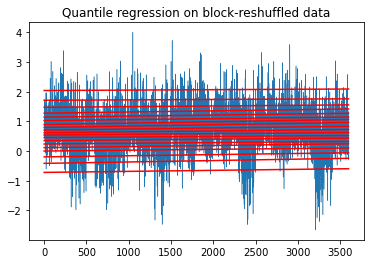

In [41]:
blocksize=100
data = timeseries.data
# data = np.arange(3600)
blocks = [data[i:i+blocksize] for i in np.arange(0, len(data), blocksize)]
shuffled = rng.permutation(blocks)
block_bootstrap = np.concatenate(shuffled)
plt.plot(block_bootstrap, lw=0.5)

df_bootstrap = pd.DataFrame.from_dict({
    'time': df.time,
    'shuffled' : block_bootstrap
})
y, x = dmatrices('shuffled ~ time', data=df_bootstrap, return_type='dataframe')

qs = np.arange(0.05, 1, 0.05)
s = np.zeros(19)
for i, q in enumerate(qs):
    qr = sm.regression.quantile_regression.QuantReg(y, x) 
    result = qr.fit(q=q)
    prediction = result.predict(x)
    plt.plot(prediction, color='r')
    s[i] = (result.predict(x).iloc[-1] - result.predict(x).iloc[0]) / len(x)

plt.title('Quantile regression on block-reshuffled data')

In [52]:
N = 1000   # Number of block bootstrap samples
B = np.random.randn(N, 19)
B

array([[ 0.07044657, -0.38985295, -0.10697314, ..., -0.14128245,
         0.29142216,  0.59984595],
       [-0.18556719,  1.23112208,  0.6201763 , ...,  0.72360068,
         1.05825026, -1.33521714],
       [-1.5260695 , -1.0828681 , -1.25124413, ...,  1.91990918,
         0.6461857 ,  0.4049079 ],
       ...,
       [-0.16527025,  1.4969238 ,  0.31716433, ..., -0.14882732,
        -1.06951123,  0.43967586],
       [-0.03484998, -0.0916423 ,  2.24578489, ...,  1.65206933,
        -0.24321129, -0.11623249],
       [ 1.6225686 , -1.10723421,  0.06440906, ...,  0.35379297,
         0.02417865, -0.71117119]])

Given the bootstrap matrix, 

In [53]:
# Create basis coefficient matrix from bootstrap samples
C = np.zeros((N, 4))
A = utils.compute_basis_matrix('legendre')

for i in range(N):
    bs_coeffs = linalg.lstsq(A, B[i, :])[0]
    C[i, :] = bs_coeffs

In [54]:
coeff_intervals = [
    pd.Interval(C[:,j].mean() - 2*C[:,j].std(), C[:,j].mean() + 2*C[:,j].std())
    for j in range(4)
]


In [55]:
# Compute significances
sigs = [coeffs[i] not in coeff_intervals[i] for i in range(4)]
sigs

[False, False, True, False]